In [6]:
# ================================================================
# CONFIGURATION SECTION
# ================================================================

import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay, classification_report)
import matplotlib.pyplot as plt


import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split

import torchvision.transforms as transforms
from torchvision.io import read_image
from torchvision import models

# -----------------------
# REPRODUCIBILITY
# -----------------------
def set_seed(seed=42):
    import random, numpy as np, torch
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

def worker_init(worker_id):
    np.random.seed(42 + worker_id)
    random.seed(42 + worker_id)


# -----------------------
# FILE PATH
# -----------------------
image_root_dir = "/kaggle/input/faceforensics-extracted-dataset-c23/FF++C32-Frames"
ORIGINAL_CSV = "/kaggle/input/faceforensics-extracted-dataset-c23/CSVs/Original.csv"
DEEPFAKES_CSV = "/kaggle/input/faceforensics-extracted-dataset-c23/CSVs/Deepfakes.csv"

# -----------------------
# TRAIN/VAL/TEST SPLITS
# -----------------------
TRAIN_SPLIT = 0.7
VAL_SPLIT = 0.15
TEST_SPLIT = 0.15

# IMAGE PREPROCESSING
BATCH_SIZE = 16
IMAGE_SIZE = (224, 224)
num_workers = 2

# HYPERPARAMETERS
LR = 1e-4
num_epochs = 200
best_val_loss = float('inf')
best_model_path = 'best_model_efficientnet_b7.pth'
patience = 30
epochs_no_improve = 0

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [7]:
# ================================================================
# BUILD DATAFRAME
# ================================================================
def build_combined_dataframe():
    df_original = pd.read_csv(ORIGINAL_CSV)
    df_deepfakes = pd.read_csv(DEEPFAKES_CSV)

    df = pd.concat([df_original, df_deepfakes], ignore_index=True)

    df['filepath'] = df.apply(
        lambda r: os.path.join(image_root_dir, r['label'], r["filename"]), axis=1
    )

    df['label_id'] = df['label'].map({"Original": 0, "Deepfakes": 1})
    return df

# ================================================================
# DATASET
# ================================================================
class FFDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.df = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = read_image(row.filepath).float() / 255.0

        if self.transform:
            img = self.transform(img)

        label = torch.tensor(row["label_id"], dtype=torch.long)
        return img, label

# ================================================================
# TRANSFORMS (EfficientNet-B7 REQUIREMENTS)
# ================================================================
def get_transforms():
    return transforms.Compose([
        transforms.Resize(IMAGE_SIZE),
        transforms.RandomHorizontalFlip(0.5),
        transforms.RandomRotation(5),
        transforms.ColorJitter(0.1, 0.1),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],  # ImageNet mean
            std=[0.229, 0.224, 0.225]    # ImageNet std
        )
    ])

In [8]:
# ================================================================
# DATA LOADING
# ================================================================
df = build_combined_dataframe()
transform = get_transforms()
all_dataset = FFDataset(df, transform=transform)

total_len = len(all_dataset)
train_len = int(TRAIN_SPLIT * total_len)
val_len = int(VAL_SPLIT * total_len)
test_len = int(TEST_SPLIT * total_len)

train_set, val_set, test_set = random_split(
    all_dataset, [train_len, val_len, test_len]
)

train_loader = DataLoader(
    train_set, batch_size=BATCH_SIZE, shuffle=True,
    num_workers=num_workers, worker_init_fn=worker_init, pin_memory=True
)
val_loader = DataLoader(
    val_set, batch_size=BATCH_SIZE, shuffle=False,
    num_workers=num_workers, worker_init_fn=worker_init, pin_memory=True
)
test_loader = DataLoader(
    test_set, batch_size=BATCH_SIZE, shuffle=False,
    num_workers=num_workers, worker_init_fn=worker_init, pin_memory=True
)

print("Train distribution:", np.bincount([y for _, y in train_set]))
print("Val distribution:", np.bincount([y for _, y in val_set]))
print("Test distribution:", np.bincount([y for _, y in test_set]))


Train distribution: [3490 3510]
Val distribution: [764 736]
Test distribution: [746 754]


In [9]:
# ================================================================
# MODEL: EfficientNet-B7 (PRETRAINED)
# ================================================================
class EfficientNetB7Binary(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = models.efficientnet_b7(weights="IMAGENET1K_V1")


        in_features = self.backbone.classifier[1].in_features

        self.backbone.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(in_features, 1)  
        )

    def forward(self, x):
        return self.backbone(x)

model = EfficientNetB7Binary().to(DEVICE)
print(model)

optimizer = optim.Adam(model.parameters(), lr=LR)
criterion = nn.BCEWithLogitsLoss()

for name, p in model.named_parameters():
    print(name, p.requires_grad)

EfficientNetB7Binary(
  (backbone): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
              (1): BatchNorm2d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
        

In [10]:
# ================================================================
# TRAINING LOOP
# ================================================================
for epoch in range(num_epochs):

    # ---------------- TRAIN ----------------
    model.train()
    train_loss = 0
    all_train_labels = []
    all_train_preds = []

    for images, labels in train_loader:
        images = images.to(DEVICE)
        labels = labels.float().to(DEVICE)

        optimizer.zero_grad()
        outputs = model(images).view(-1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        preds = torch.sigmoid(outputs).round()
        all_train_labels.extend(labels.detach().cpu().numpy())
        all_train_preds.extend(preds.detach().cpu().numpy())

    avg_train_loss = train_loss / len(train_loader)
    train_acc = accuracy_score(all_train_labels, all_train_preds)

    # ---------------- VALIDATION ----------------
    model.eval()
    val_loss = 0
    all_val_labels = []
    all_val_preds = []
    

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(DEVICE)
            labels = labels.float().to(DEVICE)

            outputs = model(images).view(-1)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            preds = torch.sigmoid(outputs).round()
            all_val_labels.extend(labels.cpu().numpy())
            all_val_preds.extend(preds.cpu().numpy())

    avg_val_loss = val_loss / len(val_loader)
    val_acc = accuracy_score(all_val_labels, all_val_preds)

    # ---------------- CHECKPOINT ----------------
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), best_model_path)
        print(f"Best model saved at: {best_model_path}")
    else:
        epochs_no_improve += 1

    print(
        f"Epoch {epoch+1}/{num_epochs} | "
        f"Train Loss: {avg_train_loss:.4f}, Acc: {train_acc:.4f} | "
        f"Val Loss: {avg_val_loss:.4f}, Acc: {val_acc:.4f}"
    )

    if epochs_no_improve >= patience:
        print("Early stopping triggered.")
        break

# ================================================================
# LOAD BEST MODEL
# ================================================================
model.load_state_dict(torch.load(best_model_path))
print("Best model loaded")


Best model saved at: best_model_efficientnet_b7.pth
Epoch 1/200 | Train Loss: 0.5465, Acc: 0.6926 | Val Loss: 0.4216, Acc: 0.8193
Best model saved at: best_model_efficientnet_b7.pth
Epoch 2/200 | Train Loss: 0.2950, Acc: 0.8724 | Val Loss: 0.2053, Acc: 0.9167
Best model saved at: best_model_efficientnet_b7.pth
Epoch 3/200 | Train Loss: 0.1853, Acc: 0.9274 | Val Loss: 0.1680, Acc: 0.9313
Epoch 4/200 | Train Loss: 0.1322, Acc: 0.9497 | Val Loss: 0.1850, Acc: 0.9313
Best model saved at: best_model_efficientnet_b7.pth
Epoch 5/200 | Train Loss: 0.1086, Acc: 0.9584 | Val Loss: 0.1306, Acc: 0.9513
Epoch 6/200 | Train Loss: 0.0872, Acc: 0.9664 | Val Loss: 0.1670, Acc: 0.9427
Best model saved at: best_model_efficientnet_b7.pth
Epoch 7/200 | Train Loss: 0.0711, Acc: 0.9733 | Val Loss: 0.1219, Acc: 0.9533
Epoch 8/200 | Train Loss: 0.0679, Acc: 0.9734 | Val Loss: 0.1493, Acc: 0.9493
Best model saved at: best_model_efficientnet_b7.pth
Epoch 9/200 | Train Loss: 0.0581, Acc: 0.9810 | Val Loss: 0.1154

Accuracy:  0.9813
Precision: 0.9853
Recall:    0.9775
F1 Score:  0.9814
Classification Report:
               precision    recall  f1-score   support

           0     0.9774    0.9853    0.9813       746
           1     0.9853    0.9775    0.9814       754

    accuracy                         0.9813      1500
   macro avg     0.9813    0.9814    0.9813      1500
weighted avg     0.9814    0.9813    0.9813      1500



<Figure size 600x500 with 0 Axes>

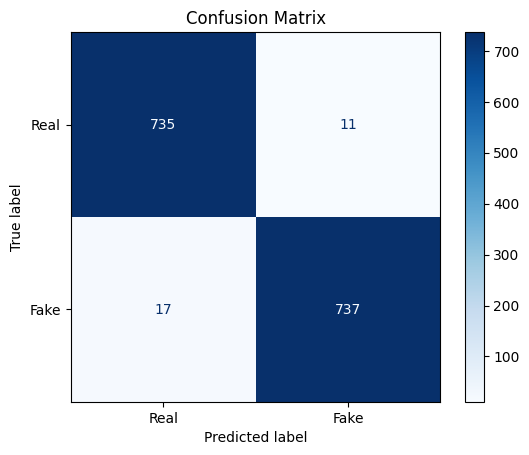

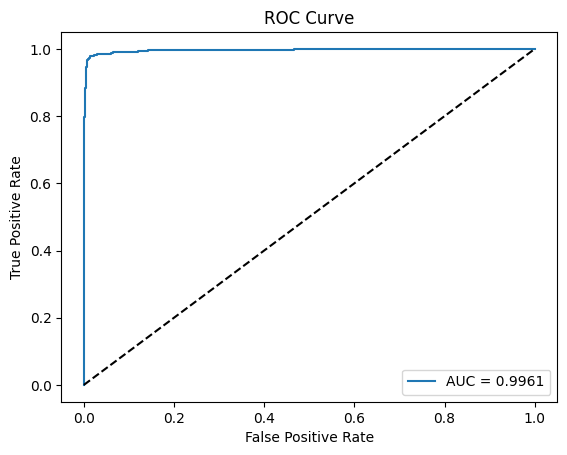

In [12]:
# ================================================================
# TEST EVALUATION
# ================================================================
model.eval()
all_labels = []
all_preds = []
all_probs = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        outputs = model(images).view(-1)
        probs = torch.sigmoid(outputs)
        preds = (probs > 0.5).float()

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())


# =================== METRICS ===================
precision = precision_score(all_labels, all_preds)
recall    = recall_score(all_labels, all_preds)
f1        = f1_score(all_labels, all_preds)
accuracy  = accuracy_score(all_labels, all_preds)
auroc = roc_auc_score(all_labels, all_probs)

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")

# Classification report
report = classification_report(all_labels, all_preds, digits=4)
print("Classification Report:\n", report)

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Real", "Fake"])

plt.figure(figsize=(6, 5))
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
plt.plot(fpr, tpr, label=f'AUC = {auroc:.4f}')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()